In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


import torch.nn.functional as F
from torch import Tensor
from torch.nn.parameter import Parameter

from torch.utils.data import DataLoader, Dataset, Subset

import observables_v as obs


from models import MajorityPooling2d, DecoderSymmetrizedConv,Decoder1layer, DegWeights, LossMagnetizationW, LossMagnetization


plt.rc('font', size=22)
plt.rc('axes', titlesize=22)
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)
plt.rcParams["figure.figsize"] = [9,6]
plt.rcParams["figure.autolayout"] = True


device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
#device=torch.device('cpu')
print(f"\nselected device: {device}\n")


selected device: cpu



In [2]:
## The dataloader class which works with compressed data where the shape of the data is L/8 columns of L*N rows. 
## The assert command is used to check the shape of the data.

class MyFantasticDataset(Dataset):
    def __init__(self, packed_data):
        super().__init__()
        assert packed_data.shape[1] == 8 * packed_data.shape[2]
        
        self.packed_data = packed_data # Nx something packed
        self.L = packed_data.shape[1]
    
    def __len__(self):
        return len(self.packed_data)
    
    def __getitem__(self, idx):
        row = np.unpackbits(self.packed_data[idx])
        row = np.reshape(row, (self.L, self.L))
        return torch.from_numpy(row).to(torch.float32)
    

In [3]:
## compute the validation loss

def validate(model, valid_dl,nv):
    
    model_originally_training = model.training
    
    model.eval()
    
    val_loss=0

    with torch.no_grad():
        for lattice in valid_dl:
            # prepare data: shape (batch, H, W) --> (batch, channel = 1, H, W)
            lattice = lattice.unsqueeze(1).to(device=device, dtype=torch.float32)

            # downsample and upsample
            lattice_down = downsampler(lattice)
            lattice_back = upsampler(lattice_down)

            # compute loss and backpropagate the gradient
            loss = criterion(lattice_back, lattice)
            val_loss+=loss.item()

    val_loss/=nv
    
    if model_originally_training:
        model.train()
    
    return val_loss

In [20]:
## load the training data and validation data
batchsize = 500

training_data = MyFantasticDataset(np.load(f"training_sets/training_data_L8.npy"))
validation_data = MyFantasticDataset(np.load(f"training_sets/validation_data_L8.npy"))

dataloader = DataLoader(training_data, batchsize, shuffle=True)#, num_workers=2)
validation_dataloader = DataLoader(validation_data, batchsize, shuffle=False)#, num_workers=2)

training_subsetsize = len(training_data)
validation_subsetsize = len(validation_data)

/Users/randy/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)


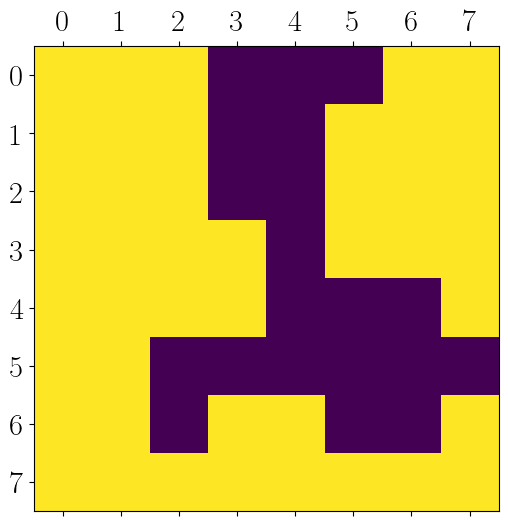

In [69]:
## Typical training configuration

plt.matshow(training_data[45])

In [23]:
## select the model to train for upsampling


pooling_method = 'FullRandom'
upsampling_method='nearest'


# define the model - the simplest 3 parameters model, kernel of size 3
mod_ref='3par_k3'
kernel_size = 3
upsampler = DecoderSymmetrizedConv(upsampling_method=upsampling_method, kernel_size=kernel_size).to(device)

#mod_ref='6par_k5'
#kernel_size = 5
#upsampler = DecoderSymmetrizedConv(upsampling_method=upsampling_method, kernel_size=kernel_size).to(device)

#mod_ref='10par_k7'
#kernel_size = 7
#upsampler = DecoderSymmetrizedConv(upsampling_method=upsampling_method, kernel_size=kernel_size).to(device)

## the ML like model, with 1 ReLu layer in the middle
#mod_ref='conv_32'
#kernel_size = 3
#upsampler = Decoder1layer(upsampling_method=upsampling_method, kernel_size=kernel_size).to(device)

In [24]:
# define the downscaling model
downsampler = MajorityPooling2d(kernel_size=(2, 2), stride=2, pooling_half=pooling_method).to(device)

In [25]:
# training hyperparameters
max_epoch = 50
learning_rate = 0.01
gamma = 0.  # not working properly for gamma != 0

criterion = LossMagnetization(gamma=gamma) 

optimizer = torch.optim.AdamW(upsampler.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs=max_epoch, steps_per_epoch=len(dataloader))



In [26]:
# training logs
loss_curve = []
loss_curve_v = []
delta_loss = 1
eps_loss = 0.0001
epoch_count = 0


# training of the model
while delta_loss > eps_loss and epoch_count < max_epoch:
    

    epoch_count += 1
    epoch_train_loss = 0.

    for lattice in dataloader:
        # prepare data: shape (batch, H, W) --> (batch, channel = 1, H, W)
        lattice = lattice.unsqueeze(1).to(device=device, dtype=torch.float32)

        # downsample and upsample
        with torch.no_grad():
            lattice_down = downsampler(lattice)
        lattice_back = upsampler(lattice_down)


        # compute loss and backpropagate the gradient
        loss = criterion(lattice_back, lattice)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        optimizer.zero_grad()

        # keep logs
        epoch_train_loss += loss.item()
        epoch_validation_loss=validate(upsampler, validation_dataloader,validation_subsetsize)

    epoch_train_loss /= training_subsetsize
    loss_curve.append(epoch_train_loss)
    loss_curve_v.append(epoch_validation_loss)
    
    print(f"epoch {epoch_count}, loss {epoch_train_loss}, validation loss {epoch_validation_loss}")
    


epoch 1, loss 0.0005754018396139145, validation loss 0.0005637706220149994
epoch 2, loss 0.0005690593183040619, validation loss 0.0005554316341876983
epoch 3, loss 0.0005602485775947571, validation loss 0.0005464189052581788
epoch 4, loss 0.0005484605640172958, validation loss 0.0005327007472515107
epoch 5, loss 0.0005348996937274932, validation loss 0.0005199321806430816
epoch 6, loss 0.000523357731103897, validation loss 0.0005099003463983536
epoch 7, loss 0.0005143081068992615, validation loss 0.0005045819580554962
epoch 8, loss 0.0005104413628578186, validation loss 0.0005005209147930145
epoch 9, loss 0.0005075311169028282, validation loss 0.0005009832382202148
epoch 10, loss 0.0005069349154829979, validation loss 0.0005008372366428376
epoch 11, loss 0.0005048215597867966, validation loss 0.0004984642714262009
epoch 12, loss 0.000503754124045372, validation loss 0.0004977828860282898
epoch 13, loss 0.0005044034913182259, validation loss 0.0004972657412290573
epoch 14, loss 0.000502

/Users/randy/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


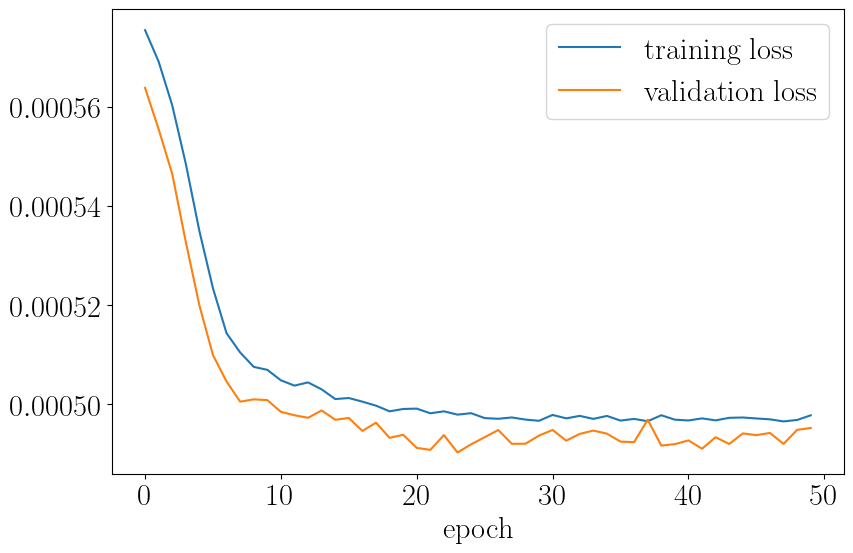

In [43]:
plt.figure()
plt.plot(loss_curve, label="training loss")
plt.plot(loss_curve_v, label = "validation loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

<Figure size 900x600 with 0 Axes>

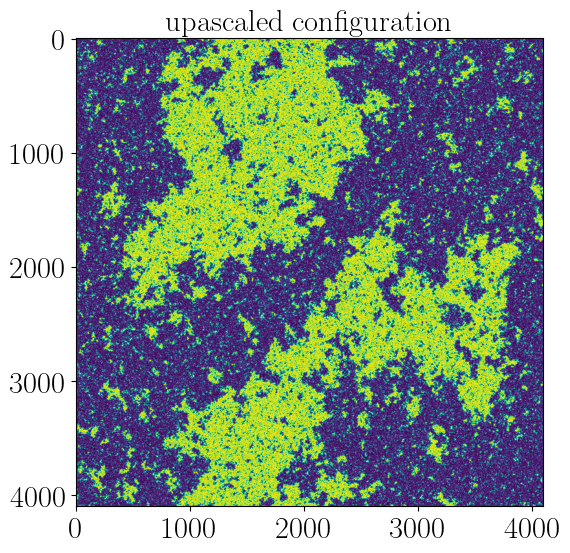

<Figure size 900x600 with 0 Axes>

In [68]:
## create randomly a system of size 1x1 and upscale it nb_up times
## !!!! if the kernel size is too large, one needs to upscale once or twice with a model of smaller kernel first

nb_up = 12

lattice = torch.tensor([[torch.randint(0, 2, (1,)).item()]]).unsqueeze(0).unsqueeze(0).to(device=device, dtype=torch.float32)

for ii in range(nb_up):
    lattice = upsampler(lattice).detach().squeeze().cpu()
    lattice = (torch.rand_like(lattice) < torch.sigmoid(lattice)).float().unsqueeze(0).unsqueeze(0).to(device=device, dtype=torch.float32)

#plt.figure()
#plt.title('orginal configuration')
#plt.imshow(lattice.detach().squeeze().cpu())
plt.figure()
plt.title('upascaled configuration')
plt.imshow(lattice.detach().squeeze().cpu())
plt.figure()